In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
!unzip -uq "/content/drive/My Drive/Copy of shopee-product-detection-dataset.zip" -d "/home/dataset"

error:  zipfile read error


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing import image
%matplotlib inline
from tqdm import tqdm
import pandas as pd
from keras import models
from keras import layers
from keras import optimizers

Using TensorFlow backend.


In [ ]:
train_df=pd.read_csv('/home/dataset/train.csv')
train_df.sort_values(by=['category','filename'],inplace=True)
train_df.reset_index(drop=True,inplace=True)
train_df

,filename,category
0,00b32bd5ba9cdd7c2f11e3975b3e54fa.jpg,0
1,00df3dd83ad6845e6fdfe675d755e17f.jpg,0
2,00df7aa7afaa7c512b9a317adb0aae24.jpg,0
3,00e6066eb828dcbe1755a4dabe189c06.jpg,0
4,012c3848585c70f971a1621bae6c8410.jpg,0
...,...,...
105387,ffb139f560e7e63cda40c7a2fd516e15.jpg,41
105388,ffc366a909c428a223a21690d86b6859.jpg,41
105389,ffc847ac22f027543ebc727e31778fc2.jpg,41
105390,ffdca50c0598b74281341481f49509ba.jpg,41


100%|██████████| 105392/105392 [02:14<00:00, 782.18it/s]


<BarContainer object of 42 artists>

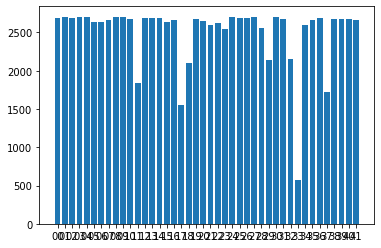

In [ ]:
from collections import Counter

category_count=Counter(label for label in train_df['category'])
category_count.keys()
plt.bar(category_count.keys(),category_count.values())

In [ ]:
img_gen=image.ImageDataGenerator(rescale=1./255,validation_split=0.1)
img_train = img_gen.flow_from_dataframe(
    train_df,
    shuffle=True,
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=32,
    subset='training'
)

img_iter_val = img_gen.flow_from_dataframe(
    train_df,
    shuffle=False,
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=32,
    subset='validation'
)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 105392 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


In [ ]:
base_model=keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling ='avg' 
)
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
# let's add a fully-connected layer
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(42, activation='softmax')(x)
model = keras.Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
opt=optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['acc'])
history = model.fit_generator(
    img_train,
    epochs=20,
    validation_data=img_iter_val
)

Epoch 1/20
2965/2965 [==============================] - 1365s 460ms/step - loss: 2.1648 - acc: 0.4248 - val_loss: 3.7689 - val_acc: 0.0000e+00
Epoch 2/20
2965/2965 [==============================] - 1347s 454ms/step - loss: 1.7027 - acc: 0.5443 - val_loss: 2.8690 - val_acc: 0.0110
Epoch 3/20
2964/2965 [============================>.] - ETA: 0s - loss: 1.5768 - acc: 0.5771

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()